# 实战 Kaggle 比赛：狗的品种识别（ImageNet Dogs）
比赛网址是 https://www.kaggle.com/c/dog-breed-identification

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

我们提供完整数据集的小规模样本

In [2]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

整理数据集

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## 图像增广

In [4]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(
        224, scale=(0.08, 0.01),
        ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

E:\software\miniconda\envs\d2l\lib\site-packages\torchvision\transforms\transforms.py:887: UserWarning: Scale and ratio should be of kind (min, max)
  warnings.warn("Scale and ratio should be of kind (min, max)")


## 读取数据集


In [5]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=True, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

## 微调预训练模型

In [6]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

## 计算损失

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')


def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

## 训练函数

In [8]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad),
        lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Animator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
                     f' examples/sec on {str(devices)}')

## 训练和验证模型

E:\software\miniconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\software\miniconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\GUMP/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

RuntimeError: uniform_ expects to return a [from, to) range, but found from=0.08 > to=0.01

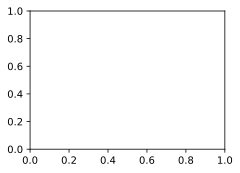

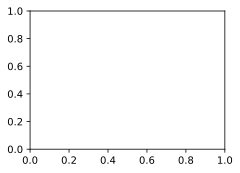

In [9]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## 对测试集分类

In [ ]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')